
# Building Job Matrices by Sector

This Jupyter Notebook aims to build job matrices by sector. 



### OD Job Matrices

* Merge people, household tables and filter by occupation and employment status, finally aggregate by pair of zones with sum of Expansion Factors.

In [18]:
import pandas as pd

equiv = pd.read_csv('../data/TAZ/equivalence_zones.csv')
mapping = dict(zip(equiv.ZONA, equiv.ZONA3))
map_type = {'F':'formal', 'P':'informal'}
people = pd.read_csv('../data/tablas/od_people.csv')
household = pd.read_csv('../data/tablas/od_households.csv')
#merge both tables
merged = pd.merge(household, people, on=['HouseholdId'], how='right')
#mapping zones
merged = merged[merged['EmploymentZone'] != 0]
merged['HouseholdZone'] = merged['HouseholdZone'].map(mapping)
merged['EmploymentZone'] = merged['EmploymentZone'].map(mapping)
typeOcc = merged['EmploymentStatus'].unique()[:-1]
#filter and aggregate by pairs of zones
for t in typeOcc:
    merged_type = merged[merged['EmploymentStatus'] == t]
    occs = merged_type['Occupation'].unique()
    print(occs)
    for occ in occs:
        merged_type_occ = merged_type[merged_type['Occupation'] == occ]
        merged_type_occ = merged_type_occ.groupby(['HouseholdZone', 'EmploymentZone'])['ExpansionFactor_y'].sum().reset_index(name='linkages')
        merged_type_occ.rename(columns={'HouseholdZone': 'HomeZone'}, inplace=True)
        merged_type_occ.to_csv(f'../data/JobData/output/{map_type[t]}/{occ}_od.csv', index=False)
        print(f'../data/JobData/output/{map_type[t]}/{occ}_od.csv')

['S' 'M' 'P' 'G']
../data/JobData/output/informal/S_od.csv
../data/JobData/output/informal/M_od.csv
../data/JobData/output/informal/P_od.csv
../data/JobData/output/informal/G_od.csv
['G' 'M' 'P' 'S']
../data/JobData/output/formal/G_od.csv
../data/JobData/output/formal/M_od.csv
../data/JobData/output/formal/P_od.csv
../data/JobData/output/formal/S_od.csv


### Workers by Zone from Synthetic Population

In [19]:
people = pd.read_csv('../data/tablas/synth_people.csv')
household = pd.read_csv('../data/tablas/synth_households.csv')
#merge both tables
merged = pd.merge(household, people, on=['HouseholdId'], how='right')
#mapping zones
merged['HouseholdZone'] = merged['HouseholdZone'].map(mapping)
typeOcc = merged['EmploymentStatus'].unique()[1:]
print(typeOcc)
for t in typeOcc:
    merged_type = merged[merged['EmploymentStatus'] == t]
    occs = merged_type['Occupation'].unique()
    print(occs)
    for occ in occs:
        merged_type_occ = merged_type[merged_type['Occupation'] == occ]
        merged_type_occ = merged_type_occ.groupby('HouseholdZone')['ExpansionFactor_y'].sum().reset_index(name='Productions')
        merged_type_occ.rename(columns={'HouseholdZone': 'HomeZone'}, inplace=True)
        merged_type_occ.to_csv(f'../data/JobData/output/{map_type[t]}/{occ}_workers.csv', index=False)
        print(f'../data/JobData/output/{map_type[t]}/{occ}_workers.csv')

['P' 'F']
['M' 'G' 'P' 'S']
../data/JobData/output/informal/M_workers.csv
../data/JobData/output/informal/G_workers.csv
../data/JobData/output/informal/P_workers.csv
../data/JobData/output/informal/S_workers.csv
['S' 'P' 'M' 'G']
../data/JobData/output/formal/S_workers.csv
../data/JobData/output/formal/P_workers.csv
../data/JobData/output/formal/M_workers.csv
../data/JobData/output/formal/G_workers.csv


### Jobs by Zone estimated with Denue and Enoe

In [20]:
import pandas as pd
import geopandas as gpd
import json
from glob import glob

equiv = pd.read_csv('../data/TAZ/equivalence_zones.csv')
mapping = dict(zip(equiv.ZONA, equiv.ZONA3))
zonas = gpd.read_file('../data/TAZ/Zonas.shp')
zonas['ZONA'] = zonas['ZONA'].map(mapping)
zonas

,ID,AREA,ZONA,MUNICIPIO,ESTADO,MACROZONA,geometry
0,760,4167.196770,18006,None,ZACATECAS,NaN,"POLYGON ((-101.91635 23.77632, -102.37350 24.0..."
1,756,319.306458,18007,None,COAHUILA,NaN,"POLYGON ((-100.88482 27.19756, -101.04433 27.3..."
2,759,2385.943600,18008,None,DURANGO,NaN,"POLYGON ((-104.04280 25.97775, -104.09193 26.4..."
3,762,130.859070,18004,None,NUEVO LEON,NaN,"POLYGON ((-100.75155 26.07842, -100.82457 26.1..."
4,758,101.798401,18009,None,COAHUILA,NaN,"POLYGON ((-100.88635 25.57731, -100.94251 25.6..."
...,...,...,...,...,...,...,...
761,727,4.980229,8020,Pesquería,NUEVO LEON,141.0,"POLYGON ((-99.99590 25.73355, -99.99637 25.762..."
762,728,1.030094,8021,Pesquería,NUEVO LEON,141.0,"POLYGON ((-99.96895 25.74568, -99.97014 25.745..."
763,765,89.058762,18003,None,NUEVO LEON,NaN,"POLYGON ((-100.04669 26.36693, -100.16183 26.4..."
764,766,791.648682,18012,None,ESTADOS UNIDOS DE AMERICA,NaN,"POLYGON ((-98.87310 26.47144, -99.07255 26.610..."


In [21]:
df = pd.read_csv('../data/JobData/denue_inegi_19_.csv', encoding='latin-1')
jobs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud, df.latitud), crs=zonas.crs)
jobsByZone = gpd.sjoin(jobs, zonas, op='within')
jobsByZone['codigo_act'] = jobsByZone['codigo_act'].apply(lambda x: int(str(x)[:2]))
mza_NL = gpd.read_file(glob('../data/JobData/nl_inegi/*.shp')[0])
mza_NL['CVE_MZA'] = mza_NL['CVE_MZA'].astype('int')
mza_NL['CVE_MUN'] = mza_NL['CVE_MUN'].astype('int')
mza_NLI = mza_NL.rename(columns={'CVE_MZA':'MZA', 'CVE_AGEB':'AGEB', 'CVE_MUN': 'MUN'}).set_index(['MUN', 'AGEB', 'MZA'])
mza_NLI = gpd.GeoDataFrame(mza_NLI).to_crs(zonas.crs)
# spatial joint between blocks and zones
zonesMza = gpd.sjoin( mza_NLI, zonas,predicate='within').reset_index()
zonesAgebMzaProp = pd.DataFrame(zonesMza.groupby(['ZONA','MUN','AGEB'])['MZA'].count().div(zonesMza.groupby('AGEB')['MZA'].count()))
df = pd.read_csv('../data/JobData/censos.csv')
df = df[df['AGEB'].notna()]
zonesJobs = zonesAgebMzaProp.reset_index().merge(df, left_on='AGEB', right_on = 'AGEB')
#Multiply total of employ with the proportion of blocks for each AGEB and for each zone. 
zonesJobs['tot_emp_prop'] = pd.to_numeric(zonesJobs['Personal Ocupado. Total'].astype(str).str.replace(',',''), errors = 'coerce') * zonesJobs.MZA
#filter rows to only consider total employ for all economic activity by AGEB
zonesJobs['label'] = zonesJobs['Descripción'].apply(lambda x: 'AGEB' in str(x) )
zonesJobs =  zonesJobs[zonesJobs.label ==True]
zonesJobs

/tmp/ipykernel_302822/3951936271.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/JobData/denue_inegi_19_.csv', encoding='latin-1')
/home/crowdcounting/anaconda3/envs/pinos/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_302822/3951936271.py:13: DtypeWarning: Columns (42,51,53,61,66,69,70,74,76,100) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/JobData/censos.csv')


,ZONA,MUN,AGEB,MZA,Entidad,Municipio,Localidad,Descripción,Unidades Económicas,Personal Ocupado. Total,...,Inversión Total,Formación Bruta de Capital Fijo,Gasto Principal,Ingreso Principal,Margen por reventa de mercancías,"TOTAL de gastos por consumo de bienes y servicios, gastos fiscales, financieros y otros","TOTAL de ingresos por suministro de bienes y servicios, ingresos financieros, subsidios y otros",Otros componentes de la producción,tot_emp_prop,label
0,1,39,0279,0.586207,19,18.0,1.0,AGEB 0279,101,207,...,0,0,27,51,13,34,52,1,121.344828,True
5,1,39,0279,0.586207,19,39.0,1.0,AGEB 0279,78,193,...,1,1,37,74,21,50,81,5,113.137931,True
10,1,39,0283,0.619048,19,18.0,1.0,AGEB 0283,11,23,...,0,0,3,4,1,3,5,0,14.238095,True
14,1,39,0283,0.619048,19,39.0,1.0,AGEB 0283,33,87,...,0,0,13,24,6,16,24,0,53.857143,True
18,1,39,0391,0.824561,19,18.0,1.0,AGEB 0391,6,13,...,0,0,1,2,1,1,2,0,10.719298,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14946,18003,44,0762,0.250000,19,18.0,1.0,AGEB 0762,10,20,...,0,1,2,4,1,3,4,0,5.000000,True
14950,18003,44,0762,0.250000,19,39.0,1.0,AGEB 0762,193,"1,298",...,13,18,412,688,78,506,724,15,324.500000,True
14955,18005,42,0166,0.422222,19,21.0,1.0,AGEB 0166,136,980,...,63,66,923,"1,440",101,"1,126","1,457",5,413.777778,True
14960,18005,42,0293,0.037037,19,21.0,1.0,AGEB 0293,57,"1,658",...,42,29,803,"1,195",213,952,"1,244",7,61.407407,True


In [49]:
denue = pd.read_csv('../data/JobData/denue_by_taz_estimated_informal_from_enoe_ratio.csv')
denue['ZONA'] = denue['ZONA'].map(mapping)
censo_proc = zonesJobs.groupby('ZONA')['tot_emp_prop'].sum()
denue_proc = denue.groupby('ZONA').sum()
merge = denue_proc.merge(censo_proc, on= 'ZONA')
merge

,sector,h,E,min,max,VAR,STD,ratio,informal,tot_emp_prop
ZONA,,,,,,,,,,
1,ComercioConstrucciónGobiernoIndustria manufact...,505,3406.246945,1620.0,24070.0,6.965101e+05,1734.724495,4.401540,2498.180654,1788.542909
2,ComercioConstrucciónGobiernoIndustria manufact...,836,5863.543677,3011.0,27945.0,7.037172e+05,109.826960,4.401540,3229.072038,3652.484540
3,ComercioConstrucciónGobiernoIndustria manufact...,888,5679.243921,2493.0,46425.0,1.391660e+06,993.827754,4.401540,3743.025242,2431.102379
4,ComercioConstrucciónGobiernoIndustria manufact...,817,9454.842872,4297.0,108330.0,3.473821e+06,915.297878,4.401540,6646.831686,3546.700460
5,Agricultura y ganaderíaComercioConstrucciónInd...,298,2039.151441,1158.0,3235.0,6.626780e+03,135.389119,7.195866,1669.960327,1664.907407
...,...,...,...,...,...,...,...,...,...,...
16011,ComercioGobiernoIndustria manufactureraOtroSer...,170,966.587182,525.0,1530.0,2.478864e+03,139.737635,2.766271,634.163030,2579.869182
17001,ComercioIndustria manufactureraServicios,4,172.043834,114.0,275.0,1.702091e+03,13.548035,1.740437,36.000344,147.200000
17002,ComercioGobiernoIndustria manufactureraOtroSer...,59,294.306703,149.0,490.0,3.075329e+02,17.047363,2.221583,194.476684,70.000000


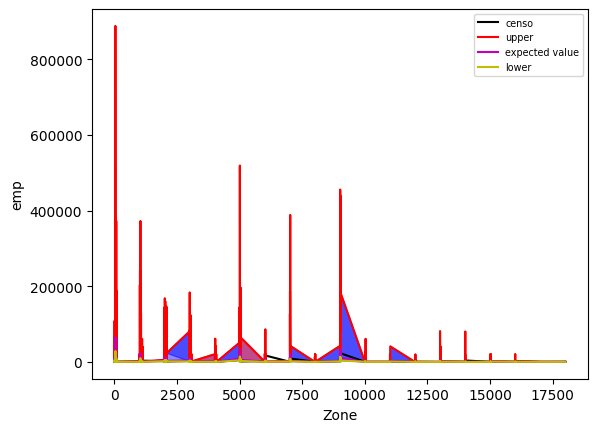

In [50]:
import matplotlib.pyplot as plt
import mpld3
mpld3.disable_notebook()

plt.figure()
plt.plot(merge['tot_emp_prop'], color='black', label='censo')
plt.plot(merge['max'], '-r', label='upper')
plt.plot(merge['E'], color='m', label='expected value')
plt.plot(merge['min'], '-y', label='lower')
# fill the area with black color, opacity 0.15
plt.fill_between(merge.index, merge['max'], merge['min'], where=(merge['tot_emp_prop'] <= merge['max']), color='blue', alpha=0.45, interpolate=True)
plt.fill_between(merge.index, merge['max'], merge['min'], where=(merge['min'] <= merge['tot_emp_prop']), color='blue', alpha=0.45, interpolate=True)
plt.fill_between(merge.index, merge['max'], merge['min'], where=(merge['tot_emp_prop'] > merge['max']), color='red', alpha=0.45, interpolate=True)
plt.fill_between(merge.index, merge['max'], merge['min'], where=(merge['min'] > merge['tot_emp_prop']), color='red', alpha=0.45, interpolate=True)

plt.xlabel("Zone")
plt.ylabel("emp")
plt.legend(fontsize='x-small')
plt.show()

In [51]:
lab = merge['E'] < merge['tot_emp_prop']
diff = merge[lab]['tot_emp_prop'] - merge[lab]['E'] 
denue['ID'] = denue.index
denue ['E'] = denue['E'].add(denue.groupby('ZONA').max().merge(pd.DataFrame(diff), on = 'ZONA').set_index('ID')[0], fill_value=0)
denue.fillna(0, inplace=True)
denue.set_index('ZONA', inplace=True)


In [52]:
sectors = {'G': ['Transporte y comunicaciones','Agricultura y ganadería', 'Gobierno', 'Otro', 'Minería'],
           'M': ['Industria manufacturera', 'Construcción'],
           'P': ['Comercio'],
           'S': ['Servicios']}
for k in sectors.keys():
    jobs_formal = [denue[denue.sector == s]['E'].reindex(zonas.ZONA, fill_value= 0) for s in sectors[k]]
    print(sum(jobs_formal).max())
    pd.DataFrame(sum(jobs_formal).fillna(0)).reset_index().rename(columns={'ZONA':'EmploymentZone','E':'Attractions'}).to_csv(f'../data/JobData/output/formal/{k}_jobs.csv', index=False)
    jobs_informal = [denue[denue.sector == s]['informal'].reindex(zonas.ZONA, fill_value= 0) for s in sectors[k]]
    print(sum(jobs_informal).max())
    pd.DataFrame(sum(jobs_informal).fillna(0)).reset_index().rename(columns={'ZONA':'EmploymentZone','E':'Attractions'}).to_csv(f'../data/JobData/output/informal/{k}_jobs.csv', index=False)

25421.706825478304
3047.0462114343613
18172.930406409738
7212.1912082449
15136.867475294212
12694.765527699716
33370.20669326703
25511.928979688957


In [53]:
denue.reset_index(inplace=True)
denue

,ZONA,sector,h,E,min,max,VAR,STD,ratio,informal,ID
0,39,Comercio,1939,15136.867475,6964.0,136065.0,4.176199e+06,56.586217,0.838665,12694.765528,0
1,39,Construcción,37,4279.235861,1642.0,81520.0,2.776507e+06,21.297945,1.635270,6997.703943,1
2,39,Gobierno,88,10617.713504,4153.0,203450.0,6.935609e+06,46.394458,0.268211,2847.788846,2
3,39,Industria manufacturera,120,1562.642638,670.0,21165.0,6.935363e+05,16.080842,0.137259,214.487265,3
4,39,Otro,33,696.399370,488.0,1040.0,1.508559e+03,52.485221,0.212935,148.287830,4
...,...,...,...,...,...,...,...,...,...,...,...
3279,18005,Industria manufacturera,1,3.000000,1.0,5.0,2.000000e+00,8.040421,0.137259,0.411778,3279
3280,18005,Otro,1,3.000000,1.0,5.0,2.000000e+00,14.027265,0.212935,0.638805,3280
3281,18005,Servicios,25,98.169234,45.0,160.0,7.704870e+01,58.243105,0.764512,75.051573,3281
3282,18005,Transporte y comunicaciones,1,224.256559,1.0,5.0,2.000000e+00,832.216349,0.544688,1.634063,3282


In [54]:
import pandas as pd

# Carga los datos de numeración
zones = pd.read_csv('../data/JobData/zones_numbering.csv')

# Extrae los rangos de numeración
zones[['start', 'end']] = zones['Numbering Range'].str.split(' - ', expand=True)
zones['start'] = zones['start'].astype(int)
zones['end'] = zones['end'].astype(int)

# Función para buscar municipio por zona
def get_region(zona):
    for _, row in zones.iterrows():
        if row['start'] <= zona <= row['end']:
            return row['Region']
    return None

# Si denue tiene la columna 'ZONA'
denue['Municipio'] = denue['ZONA'].astype(int).apply(get_region)
denue

,ZONA,sector,h,E,min,max,VAR,STD,ratio,informal,ID,Municipio
0,39,Comercio,1939,15136.867475,6964.0,136065.0,4.176199e+06,56.586217,0.838665,12694.765528,0,Monterrey
1,39,Construcción,37,4279.235861,1642.0,81520.0,2.776507e+06,21.297945,1.635270,6997.703943,1,Monterrey
2,39,Gobierno,88,10617.713504,4153.0,203450.0,6.935609e+06,46.394458,0.268211,2847.788846,2,Monterrey
3,39,Industria manufacturera,120,1562.642638,670.0,21165.0,6.935363e+05,16.080842,0.137259,214.487265,3,Monterrey
4,39,Otro,33,696.399370,488.0,1040.0,1.508559e+03,52.485221,0.212935,148.287830,4,Monterrey
...,...,...,...,...,...,...,...,...,...,...,...,...
3279,18005,Industria manufacturera,1,3.000000,1.0,5.0,2.000000e+00,8.040421,0.137259,0.411778,3279,External Zones
3280,18005,Otro,1,3.000000,1.0,5.0,2.000000e+00,14.027265,0.212935,0.638805,3280,External Zones
3281,18005,Servicios,25,98.169234,45.0,160.0,7.704870e+01,58.243105,0.764512,75.051573,3281,External Zones
3282,18005,Transporte y comunicaciones,1,224.256559,1.0,5.0,2.000000e+00,832.216349,0.544688,1.634063,3282,External Zones


In [58]:
denue.groupby('Municipio')['E'].sum().reset_index().to_csv('../data/JobData/denue_municipio_jobs.csv', index=False)

In [59]:
denue.groupby('Municipio')['informal'].sum().reset_index().to_csv('../data/JobData/denue_municipio_informal_jobs.csv', index=False)